# MSA 2024 Phase 2 - Part 2

In [35]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Load and split preprocessed data

In [36]:
# Load and describe the dataset

df = pd.read_csv("../0. Resources/datasets/X store sales/preprocessed_store_sales.csv", encoding='latin_1')
df.head()

,Order Date,Sales,Year,Month
0,2014-01-07,76.73,2014,1
1,2014-01-10,51.94,2014,1
2,2014-01-11,9.94,2014,1
3,2014-01-13,879.94,2014,1
4,2014-01-14,61.96,2014,1


In [37]:
#df = df.groupby(["Year","Month"])["Sales"].sum().round(2)

df = df.copy()

df['Time'] = np.arange(len(df.index))

df.head()

,Order Date,Sales,Year,Month,Time
0,2014-01-07,76.73,2014,1,0
1,2014-01-10,51.94,2014,1,1
2,2014-01-11,9.94,2014,1,2
3,2014-01-13,879.94,2014,1,3
4,2014-01-14,61.96,2014,1,4


In [38]:
# Split the preprocessed datasets into a training set and a test set
X, y = df.loc[:, ['Time']], df.loc[:, 'Sales']
# Create an 70-30 train-test split on the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 616 rows
Test Set: 264 rows


## 2. Choose an algorithm

In [39]:
# Since we are 

# Fit a linear regression model on the training set
model = LinearRegression().fit(X_train, y_train)
print (model)

LinearRegression()


## 3. Train and test a model

In [40]:
# Get predictions using the features of a test set
predictions = model.predict(X_test)


np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels   : ' ,y_test[:10])

# Test a model using predictions and the targets of a test set
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

Predicted labels:  [679. 683. 580. 612. 732. 665. 769. 623. 693. 616.]
Actual labels   :  408      92.47
423     354.90
16       20.32
141     555.84
617    1002.84
354      29.22
766     418.30
185     182.39
462    2072.46
157     100.38
Name: Sales, dtype: float64
MSE: 395668.96102676133


Text(0.5, 1.0, 'Time Series of Sales')

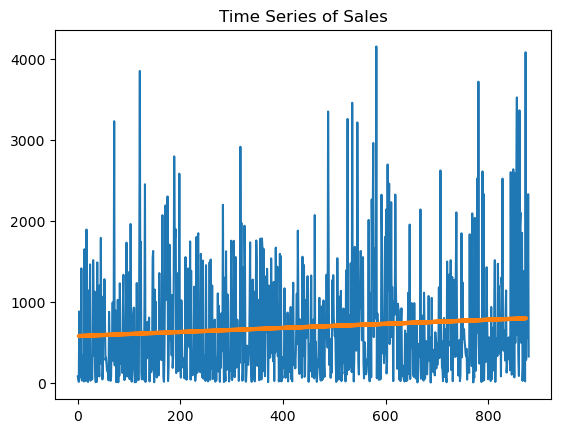

In [56]:
y_pred = pd.Series(predictions, index=X_test.index)
ax = y.plot()
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Series of Sales')

## 4. Evaluate the model 

In [42]:
#

## 5. Summary